In [3]:
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from Bio import SeqIO
from Bio import Entrez

def read_fasta(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    sequence = ''
    header = ''
    header = lines[0].strip()
    sequence = ''.join(line.strip() for line in lines[1:])
    return header, sequence

def calculate_gc_skew(sequence, window_size, window_pass):
    genome_positions = []
    gc_skew_values = []
    cumulative_gc_skew_values = []
    g_count = 0
    c_count = 0
    cumulative_gc_skew = 0
    min_cumulative_gc_skew = float('inf')
    max_cumulative_gc_skew = float('-inf')
    pos_min_cumulative_gc_skew = 0
    pos_max_cumulative_gc_skew = 0
    for i in range(len(sequence)):
        if i % window_pass == 0:
            window_start = max(0, i - window_size)
            window_end = i

            window_sequence = sequence[window_start:window_end]
            g_count_in_window = window_sequence.upper().count('G')
            c_count_in_window = window_sequence.upper().count('C')

            gc_skew = (g_count_in_window - c_count_in_window) / (g_count_in_window + c_count_in_window) if (g_count_in_window + c_count_in_window) != 0 else 0

            g_count += g_count_in_window
            c_count += c_count_in_window
            cumulative_gc_skew += gc_skew

            if cumulative_gc_skew < min_cumulative_gc_skew:
                min_cumulative_gc_skew = cumulative_gc_skew
                pos_min_cumulative_gc_skew = i

            if cumulative_gc_skew > max_cumulative_gc_skew:
                max_cumulative_gc_skew = cumulative_gc_skew
                pos_max_cumulative_gc_skew = i

            genome_positions.append(i)
            gc_skew_values.append(gc_skew)
            cumulative_gc_skew_values.append(cumulative_gc_skew)

    return genome_positions, gc_skew_values, cumulative_gc_skew_values, pos_min_cumulative_gc_skew, pos_max_cumulative_gc_skew

def plot_gc_skew2(nom, genome_positions, gc_skew_values, cumulative_gc_skew_values, pos_min_cumulative_gc_skew, pos_max_cumulative_gc_skew, window_size, window_pass):

    fig, ax1 = plt.subplots(figsize=(10, 6))

    color = 'tab:gray'
    ax1.set_xlabel('Genome Position (nt)')
    ax1.set_ylabel('GC Skew', color=color)
    ax1.plot(genome_positions, gc_skew_values, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('Cumulative GC Skew', color=color)
    ax2.plot(genome_positions, cumulative_gc_skew_values, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    # Draw positive GC skew in green and negative GC skew in red
    ax1.fill_between(genome_positions, 0, gc_skew_values, where=[gc_skew >= 0 for gc_skew in gc_skew_values], interpolate=True, color='red', alpha=0.3)
    ax1.fill_between(genome_positions, 0, gc_skew_values, where=[gc_skew < 0 for gc_skew in gc_skew_values], interpolate=True, color='green', alpha=0.3)

    ax2.axvline(x=pos_min_cumulative_gc_skew, linestyle='--', color='green', label=f'Min Cumulative GC Skew (Genome Position): {pos_min_cumulative_gc_skew}')
    ax2.axvline(x=pos_max_cumulative_gc_skew, linestyle='--', color='red', label=f'Max Cumulative GC Skew (Genome Position): {pos_max_cumulative_gc_skew}')

    fig.tight_layout()

    # Add grid
    ax1.grid(True, linestyle='--', alpha=0.7)

    ax1.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
    
    plt.title(f'{nom}\nGC Skew and Cumulative GC Skew (in blue) (Window Size: {window_size}, Window Pass: {window_pass})')
    plt.legend()
    plt.show()



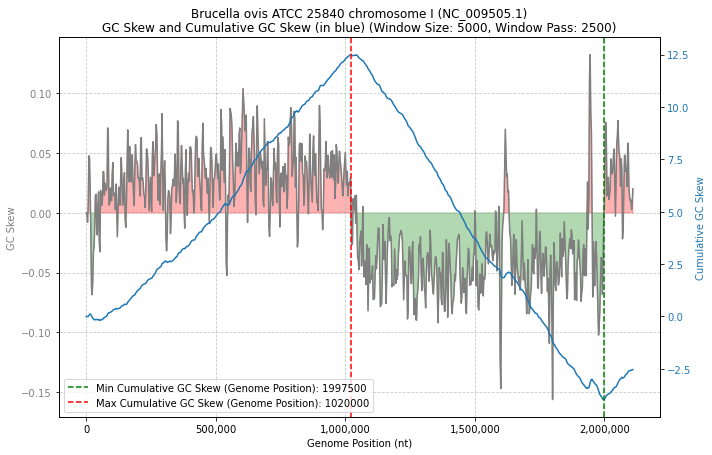

In [13]:
def main():
    # Define window size and window pass
    window_size = 5000
    window_pass = window_size // 2

    # Read a fasta file or download it using Biopython

    # Read the FASTA file
    #fasta_file_path = 'Bacillus_amyloliquefaciens.fta'  # Update with your file path
    # fasta_file_path = 'Bacteroides_thet.fta'
    # header, sequence = read_fasta(fasta_file_path)
    # if header.count('|') > 3:
    #     name=header.split('|')[4]+' ('+header.split('|')[3]+')'
    # else:
    #     name = header[1:]

    # Download from Biopython
    Entrez.email = "A.N.Other@example.com"
    with Entrez.efetch(
        db="nucleotide", rettype="fasta", retmode="text", id="NC_009505.1" # Brucella_ovis.fta
    ) as handle:
        record = SeqIO.read(handle, "fasta")
    sequence = str(record.seq)
    header = str(record.description)
    if header.count(',') > 0:
        name=" ".join(header.split(',')[0].split(' ')[1:]) + ' (' + header.split(',')[0].split(' ')[0] + ')' 


    # Calculate GC skew and cumulative GC skew with sliding window
    genome_positions, gc_skew_values, cumulative_gc_skew_values, pos_min_cumulative_gc_skew, pos_max_cumulative_gc_skew = calculate_gc_skew(sequence, window_size, window_pass)

    # Plot the results
    plot_gc_skew2(name, genome_positions, gc_skew_values, cumulative_gc_skew_values, pos_min_cumulative_gc_skew, pos_max_cumulative_gc_skew, window_size, window_pass)



if __name__ == "__main__":
    main()